# Model 0

## Model specification

We will model choices as arising from a simple reinforcement learning model. We assume no effects of age group, delay, or previous outcome on learning.

For each trial, given options $A$ and $B$, we assume that the probability of choosing $A$ is given by
$$
p(A) = \frac{e^{\beta Q_A}}{e^{\beta Q_A} + e^{\beta Q_B}}
$$
or equivalently
$$
\text{logit} (p(A)) = \beta (Q_A - Q_B)
$$
where $\beta$ is a parameter and $Q_A$ is the value function for option $A$ defined as follows:

Since each reward in the task is present or not, we can model $Q_A$ as the probability of reward. We assume that on each trial, we update our estimate of the observed cue as 
$$
Q_{t+1} \leftarrow Q_t + \alpha (R_t - Q_t)
$$
with $R_t \in \{0, 1\}$ the outcome of trial $t$.

## Priors

We model the priors as follows:
$$
\alpha \sim \text{Be}(1, 1) \\
\beta \sim \mathcal{N}(0, 5)
$$

## Variants

### Biases

We can also include a bias for particular cues, irrespective of their outcomes:
$$
\text{logit} (p(A)) = \beta (Q_A - Q_B) + \beta_{0A} - \beta_{0B}
$$

### Correlated learning

Since, for each pair of targets, the values of the targets are perfectly anticorrelated, we can simultaneously update both cues according to the outcome observed for a single one:
$$
Q_{A} \leftarrow Q_{A} + \alpha\Delta_A \\
Q_{B} \leftarrow Q_{B} + \alpha\Delta_B
$$
where
$$
\Delta_A = R - Q_A \\
\Delta_B = (1 - R) - Q_B
$$
In other words, receiving an outcome $R$ from choosing $A$ is *simultaneously* equivalent to receiving an outcome $1-R$ from $B$.

## Ready the data...

In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import pystan
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
df = pd.read_csv("data/test_data.csv")

In [3]:
df.head()

,SubjNum,AgeGroup,TrialNum,RunNum,DelayCond,Outcome,Chosen,Unchosen,Trial
0,1,1,1,1,2,1.0,4.0,8,1
1,1,1,2,1,2,1.0,4.0,8,2
2,1,1,3,1,2,1.0,4.0,8,3
3,1,1,4,1,1,NaN,NaN,1,4
4,1,1,5,1,2,1.0,4.0,8,5


Stan requires a dictionary of data, so let's make one

In [4]:
ddict = {}
ddict['N'] = df.shape[0]
ddict['Nsub'] = len(df['SubjNum'].unique())
ddict['Ncue'] = sum(~np.isnan(df['Chosen'].unique()))
ddict['Ntrial'] = np.max(df['Trial'])
ddict['sub'] = df['SubjNum']
ddict['chosen'] = df['Chosen'].fillna(0).astype('int')
ddict['unchosen'] = df['Unchosen'].fillna(0).astype('int')
ddict['trial'] = df['Trial']
ddict['outcome'] = df['Outcome'].fillna(-1).astype('int')
ddict['group'] = df[['AgeGroup', 'SubjNum']].drop_duplicates()['AgeGroup']

In [5]:
np.random.seed(77752)

In [6]:
sm = pystan.StanModel(file='model0.stan')

In [7]:
def initfun():
    return {'beta': np.zeros((ddict['Nsub'],)), 
            'alpha': np.random.rand(ddict['Nsub'],),
            'alphau': np.random.rand(ddict['Nsub'],)}

In [8]:
fit = sm.sampling(data=ddict, chains=1, init=initfun)

/Users/jmxp/anaconda/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [9]:
samples = fit.extract()

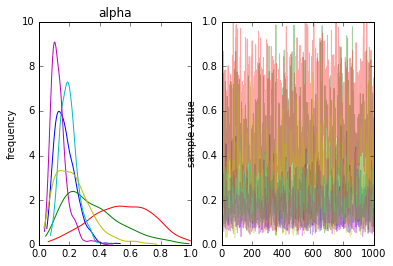

In [10]:
fit.plot('alpha');

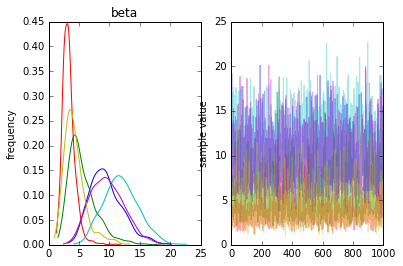

In [12]:
fit.plot('beta');

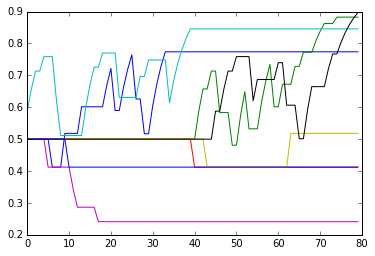

In [13]:
# plot mean posterior Q values across task
subj = 0
plt.plot(np.mean(samples['Q'], 0)[subj]);

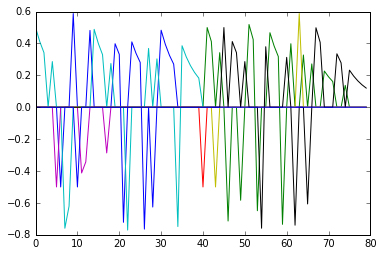

In [14]:
# plot mean posterior RPE values across task
subj = 0
plt.plot(np.mean(samples['Delta'], 0)[subj]);